In [1]:
!pip install fiftyone
!pip install pyzbar
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.0/564.0 kB 6.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 42.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import fiftyone as fo

In [4]:
dataset = fo.Dataset.from_dir(
    data_path="/home/jovyan/work/data/",
    labels_path="/home/jovyan/work/output_9-28/leaves_val.json",
    dataset_type=fo.types.COCODetectionDataset, 
    name="val_9-12_10-11",
    label_types="segmentations"
)


 100% |███████████████████| 39/39 [8.3s elapsed, 0s remaining, 4.0 samples/s]      


In [4]:
print(dataset)

Name:        val_9-12_1467
Media type:  image
Num samples: 39
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms

In [8]:
base_path = "/home/jovyan/work/output_9-28/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

[10/11 17:36:28 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [9]:
from IPython.display import display


In [10]:


with fo.ProgressBar() as pb:
    for sample in pb(dataset):

        # run interence on selected image
        image = Image.open(sample.filepath)
        image = ImageOps.exif_transpose(image)
        
        image_arr = np.array(image)
        h, w, c = image_arr.shape
        print (h,w,c)
        outputs = leaf_predictor(image_arr)
        

        # get bboxes and class labels
        pred_boxes = outputs["instances"].pred_boxes.tensor.numpy()
        pred_masks = outputs["instances"].pred_masks.numpy()
        class_labels = outputs["instances"].pred_classes.numpy()
        scores = outputs["instances"].scores.numpy()
        
        # print(pred_masks)
        
        qr_indices = []
        leaf_indices = []
        
        # get indices of leaves and qr codes
        for i, label in enumerate(class_labels):
            if label == 0: # leaf
                leaf_indices.append(i)
            elif label == 1: # qr
                qr_indices.append(i)
        
        # print('QR:', qr_indices)
        # print('Leaves:',leaf_indices)
        classes = ['leaf', 'qr', 'red-square']
        
        detections = []
        for label, mask, box, score in zip(class_labels, pred_masks, pred_boxes, scores):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            
            bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
            mask_h, mask_w = bbox_mask.shape
            # print (mask_h, mask_w)
            # count = np.count_nonzero(bbox_mask)
            # print('maskpixels: ', count)
            
            # print(mask.shape)
            # print(np.count_nonzero(mask))
            
            # print(rel_box)
            
            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                )
            )
        
        sample["predictions"] = fo.Detections(detections=detections)
        sample["height"] = h
        sample["width"] = w
        
        sample.save()


        

   0% ||------------------|  0/39 [14.9ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


4640 6960 3                                                                  
4640 6960 3                                                                     
4640 6960 3                                                                     
4640 6960 3                                                                     
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3                                                                      
4640 6960 3            

In [ ]:
print(dataset.last())

In [13]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

In [ ]:
session.refresh()

In [10]:
import matplotlib.pyplot as plt
# [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

def convert_to_pixels(fo_format, h, w):
    x1, y1, x2, y2 = fo_format
    return [x1 * w, y1 * h, (w * x2) + (x1 * w), (h * y2) + (y1 * h)]


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6157.JPG
Prediction pixel count:  63479
Ground truth pixel count:  59201
IOU: 0.8646077149892087
Dice: 0.9273883273557222


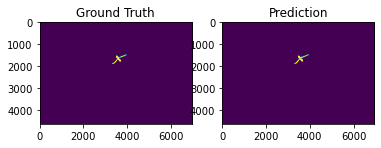


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5983.JPG
Prediction pixel count:  1518320
Ground truth pixel count:  1481513
IOU: 0.844815901722416
Dice: 0.915880984041445


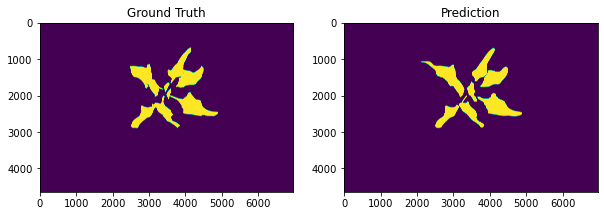


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5978.JPG
Prediction pixel count:  20145
Ground truth pixel count:  20180
IOU: 0.247833890332962
Dice: 0.39722256664600125


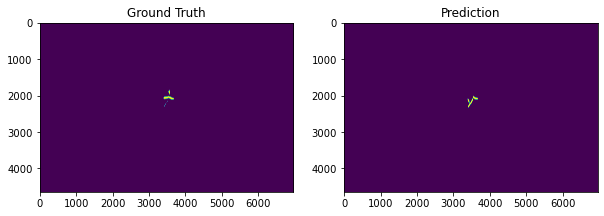


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5925.JPG
Prediction pixel count:  56942
Ground truth pixel count:  4330
IOU: 0.0752680624045768
Dice: 0.13999869434652043


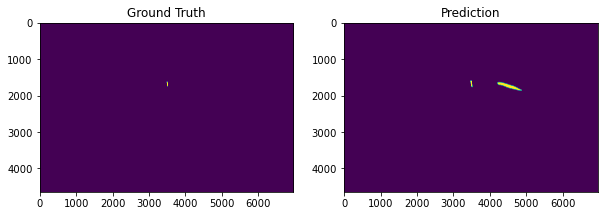


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5868.JPG
Prediction pixel count:  0
Ground truth pixel count:  4970
IOU: 0.0
Dice: 0.0


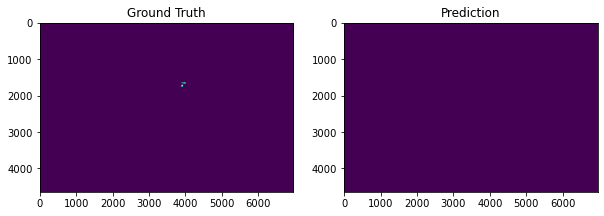


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5878.JPG
Prediction pixel count:  0
Ground truth pixel count:  0
IOU: None
Dice: None


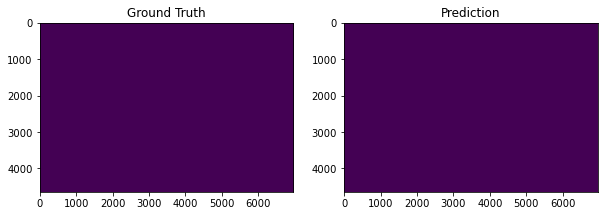


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6145.JPG
Prediction pixel count:  167803
Ground truth pixel count:  175877
IOU: 0.8959876866721466
Dice: 0.9451408286778399


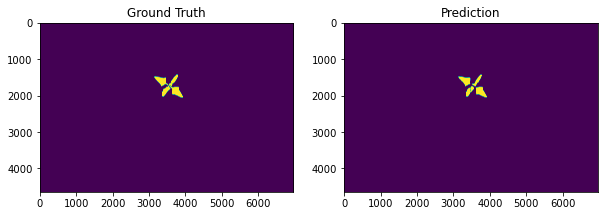


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6159.JPG
Prediction pixel count:  0
Ground truth pixel count:  1432
IOU: 0.0
Dice: 0.0


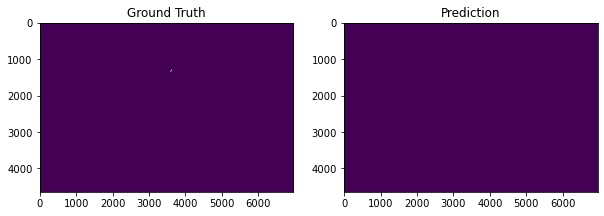


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5952.JPG
Prediction pixel count:  29320
Ground truth pixel count:  34584
IOU: 0.7364745523219478
Dice: 0.8482411116675013


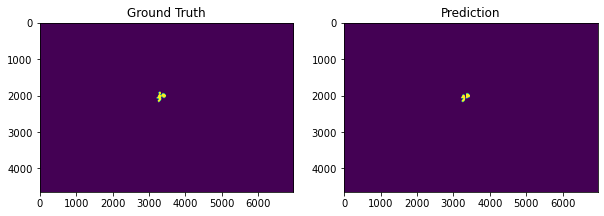


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5949.JPG
Prediction pixel count:  164038
Ground truth pixel count:  165881
IOU: 0.8910434244314013
Dice: 0.9423828273000342


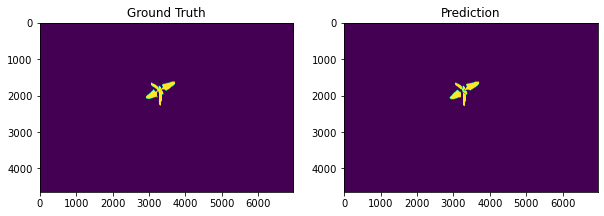


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5872.JPG
Prediction pixel count:  146209
Ground truth pixel count:  141635
IOU: 0.8732404448754075
Dice: 0.9323314017314934


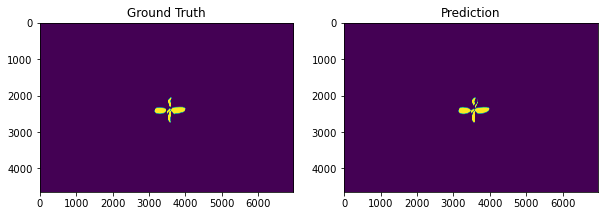


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5870.JPG
Prediction pixel count:  270514
Ground truth pixel count:  304046
IOU: 0.7757009345794392
Dice: 0.8736842105263158


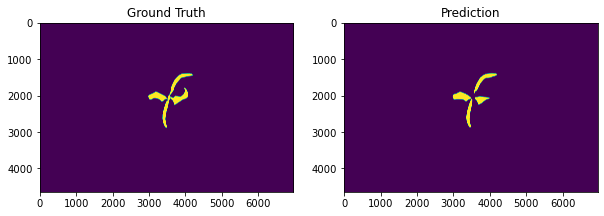


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6053.JPG
Prediction pixel count:  1365652
Ground truth pixel count:  1401835
IOU: 0.9288782483542601
Dice: 0.9631279207454272


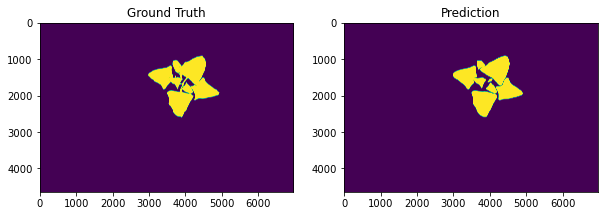


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5869.JPG
Prediction pixel count:  27483
Ground truth pixel count:  25281
IOU: 0.8254281266216917
Dice: 0.9043666136001819


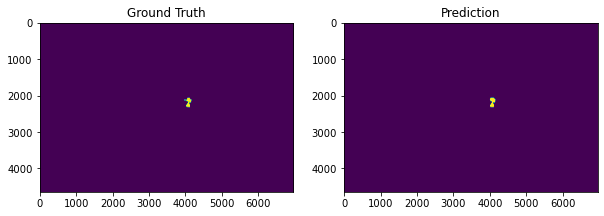


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6052.JPG
Prediction pixel count:  160259
Ground truth pixel count:  172114
IOU: 0.8783335499658097
Dice: 0.9352263872215854


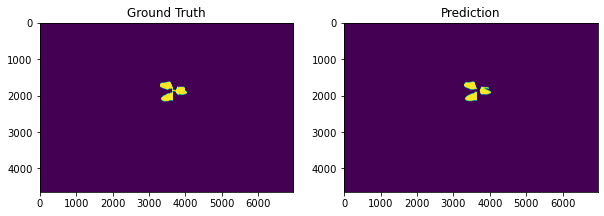


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6047.JPG
Prediction pixel count:  512899
Ground truth pixel count:  573611
IOU: 0.8488500309698673
Dice: 0.9182464956604173


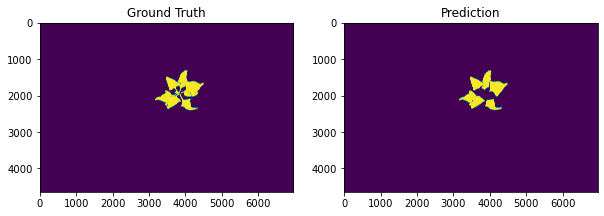


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6046.JPG
Prediction pixel count:  500790
Ground truth pixel count:  556291
IOU: 0.8268654807640794
Dice: 0.9052286437841566


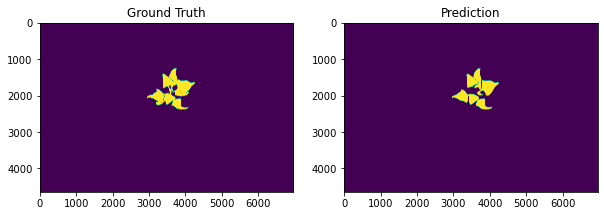


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6043.JPG
Prediction pixel count:  29277
Ground truth pixel count:  29775
IOU: 0.8563390022319324
Dice: 0.9226105805053173


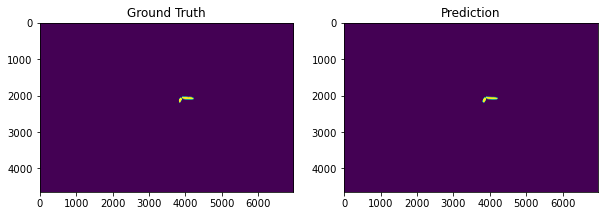


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6023.JPG
Prediction pixel count:  302828
Ground truth pixel count:  333171
IOU: 0.8004880575930607
Dice: 0.8891900773428889


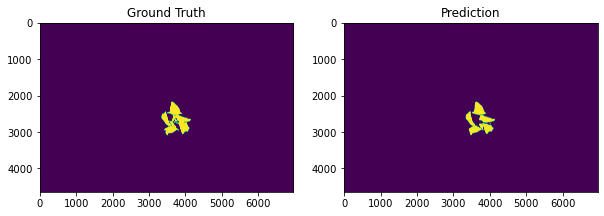


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6022.JPG
Prediction pixel count:  230442
Ground truth pixel count:  223012
IOU: 0.868079987476209
Dice: 0.9293820321355639


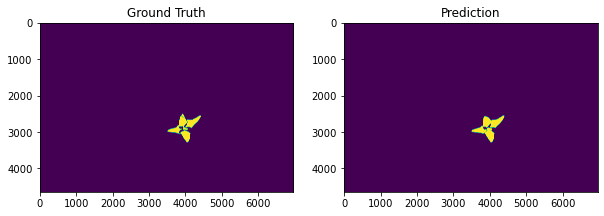


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6020.JPG
Prediction pixel count:  1152539
Ground truth pixel count:  1313928
IOU: 0.785146284074024
Dice: 0.8796436360186453


/tmp/ipykernel_1430513/4010168736.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)


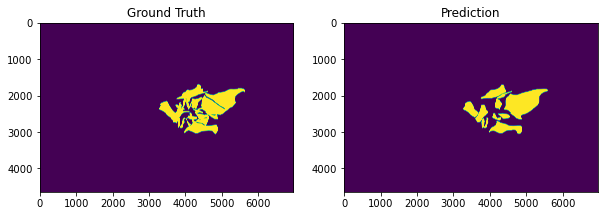


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5976.JPG
Prediction pixel count:  480039
Ground truth pixel count:  542192
IOU: 0.7931045975196899
Dice: 0.8846160994921891


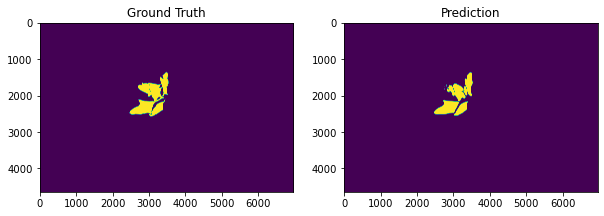


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5959.JPG
Prediction pixel count:  256054
Ground truth pixel count:  274445
IOU: 0.8662391253108939
Dice: 0.9283259723392504


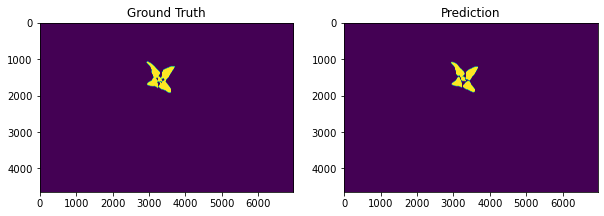


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5863.JPG
Prediction pixel count:  117226
Ground truth pixel count:  124999
IOU: 0.859835687960688
Dice: 0.9246361853648467


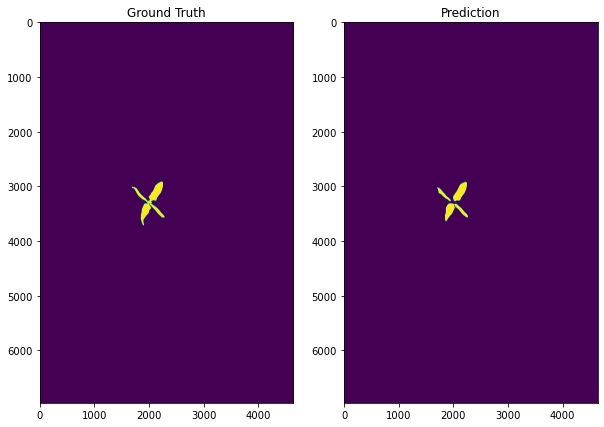


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5920.JPG
Prediction pixel count:  9615
Ground truth pixel count:  15125
IOU: 0.45341322993772765
Dice: 0.6239288601455133


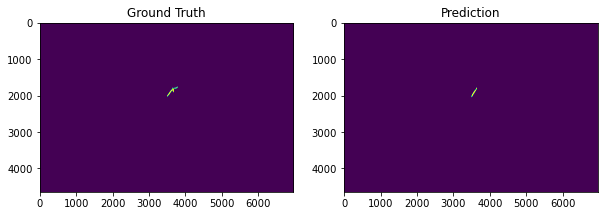


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6014.JPG
Prediction pixel count:  0
Ground truth pixel count:  22409
IOU: 0.0
Dice: 0.0


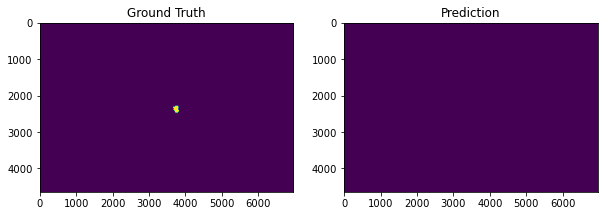


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6008.JPG
Prediction pixel count:  19524
Ground truth pixel count:  19749
IOU: 0.8972463768115942
Dice: 0.945840653884348


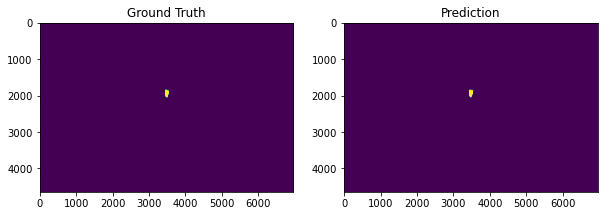


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6007.JPG
Prediction pixel count:  161306
Ground truth pixel count:  180412
IOU: 0.7656377558928996
Dice: 0.8672648207001095


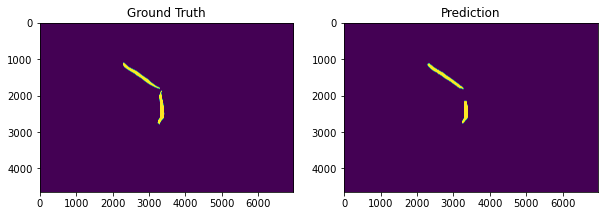


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6001.JPG
Prediction pixel count:  2088477
Ground truth pixel count:  2391372
IOU: 0.8103201424705319
Dice: 0.895223030954838


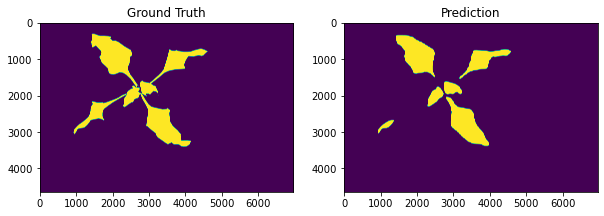


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5999.JPG
Prediction pixel count:  914899
Ground truth pixel count:  913927
IOU: 0.846083185619168
Dice: 0.9166252010852864


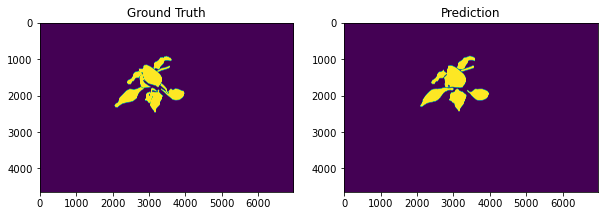


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5998.JPG
Prediction pixel count:  583020
Ground truth pixel count:  607758
IOU: 0.904592667470658
Dice: 0.9499066996535038


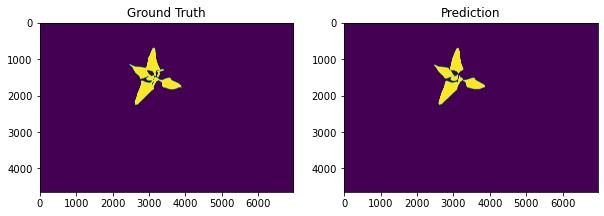


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5997.JPG
Prediction pixel count:  643865
Ground truth pixel count:  659430
IOU: 0.9086137638042964
Dice: 0.9521190520948826


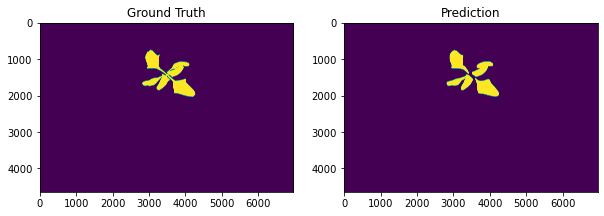


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5995.JPG
Prediction pixel count:  982969
Ground truth pixel count:  991200
IOU: 0.899728152350159
Dice: 0.9472177913846281


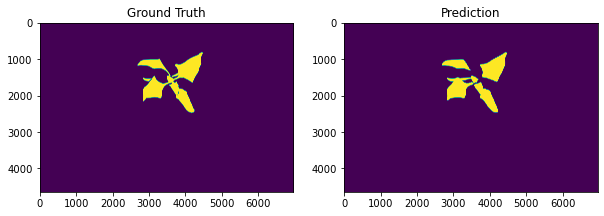


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5943.JPG
Prediction pixel count:  65609
Ground truth pixel count:  66633
IOU: 0.8348850439150283
Dice: 0.9100134601715038


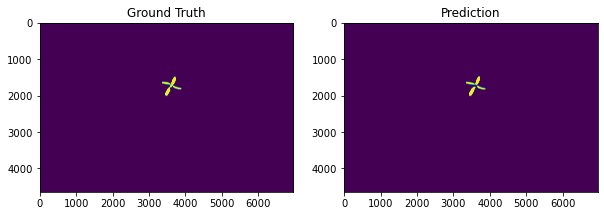


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5979.JPG
Prediction pixel count:  91940
Ground truth pixel count:  114977
IOU: 0.7349057157470213
Dice: 0.8471996017726915


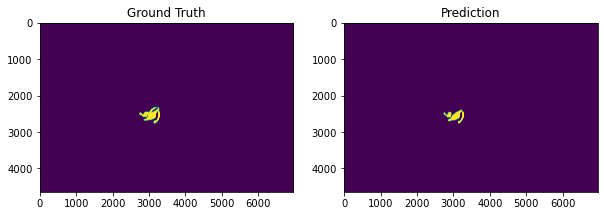


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5977.JPG
Prediction pixel count:  17438
Ground truth pixel count:  23853
IOU: 0.6363888558633536
Dice: 0.777796614274297


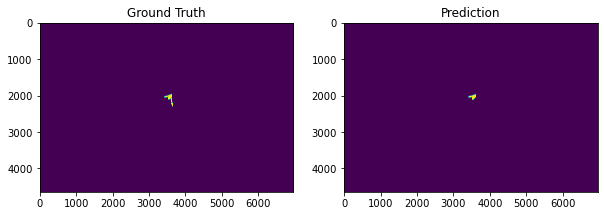


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5913.JPG
Prediction pixel count:  33038
Ground truth pixel count:  37103
IOU: 0.8118203187559735
Dice: 0.8961377796153462


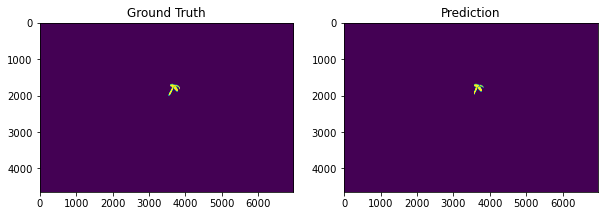


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5967.JPG
Prediction pixel count:  723262
Ground truth pixel count:  812424
IOU: 0.8563904439203475
Dice: 0.9226404356098838


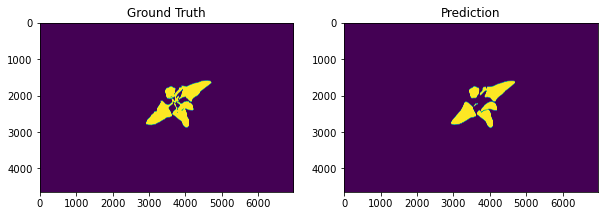


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5905.JPG
Prediction pixel count:  1877890
Ground truth pixel count:  1918151
IOU: 0.9117352889630207
Dice: 0.9538300561031875


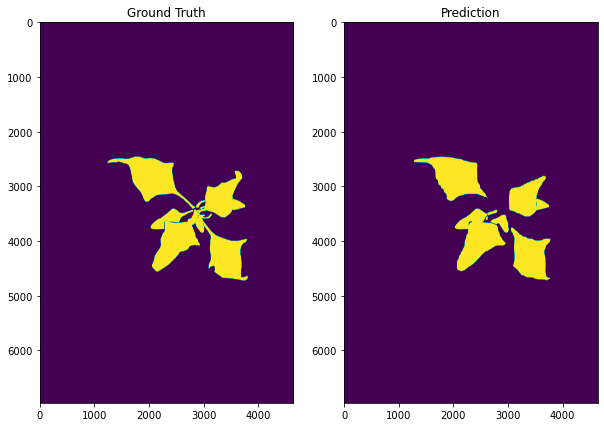

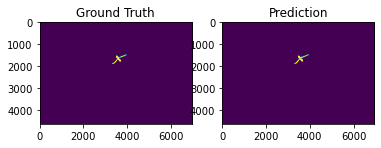

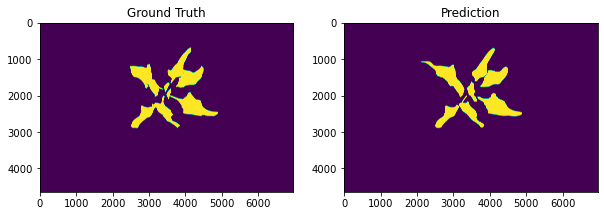

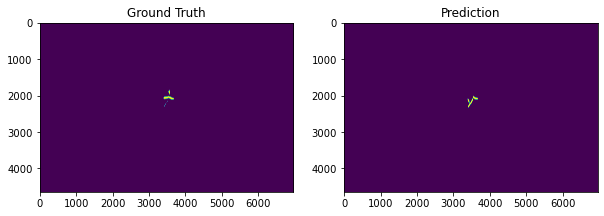

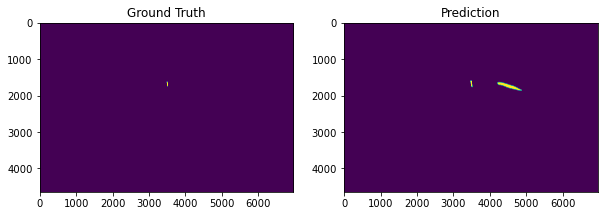

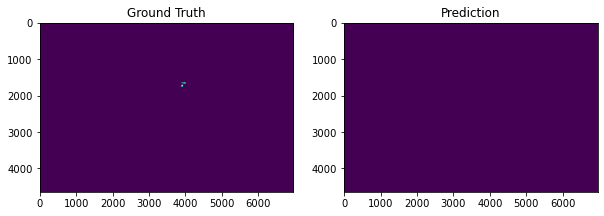

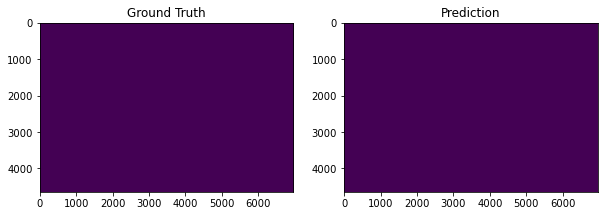

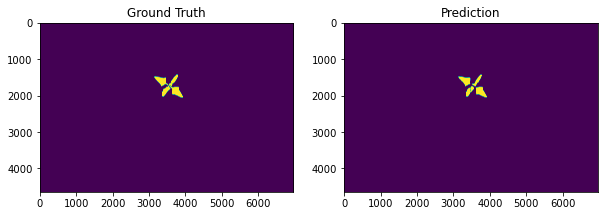

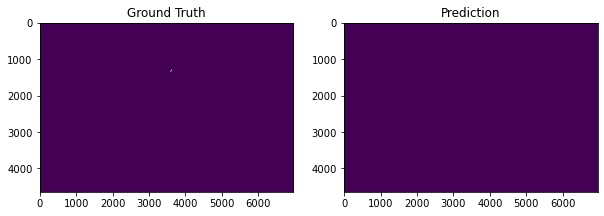

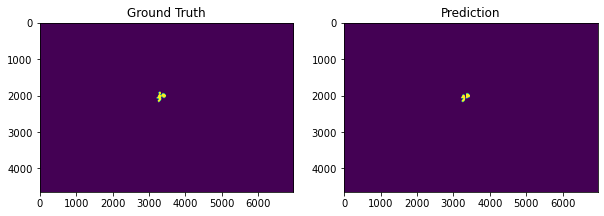

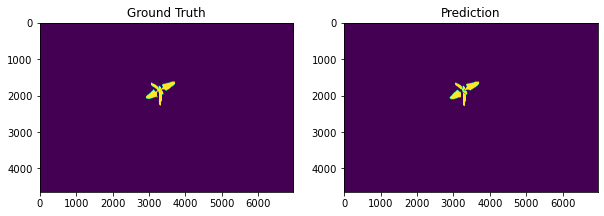

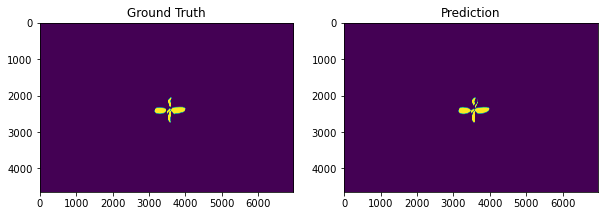

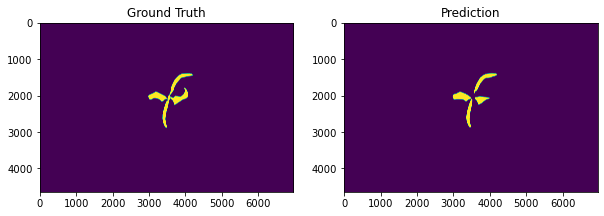

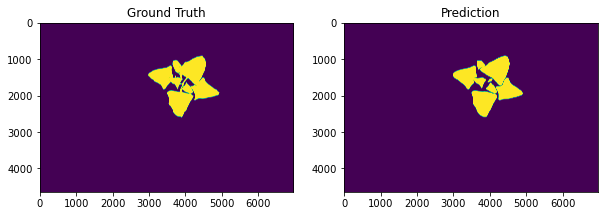

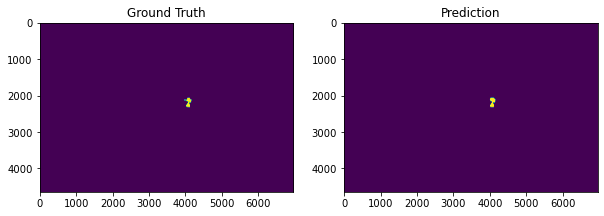

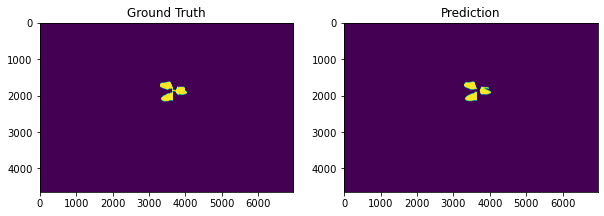

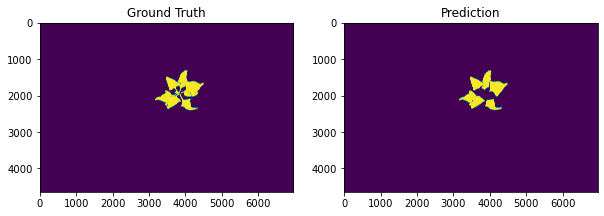

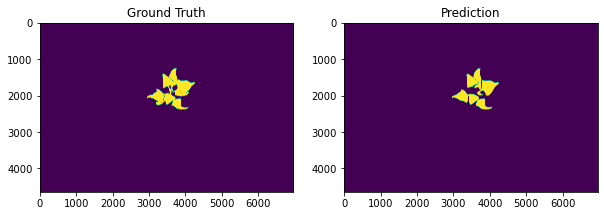

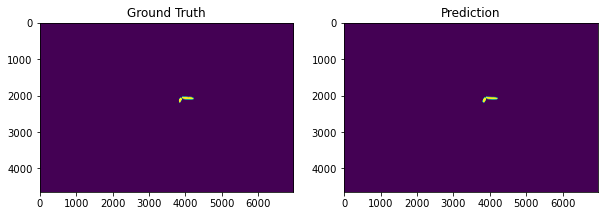

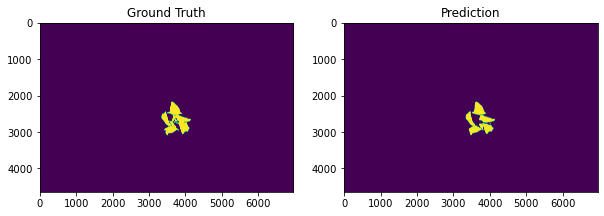

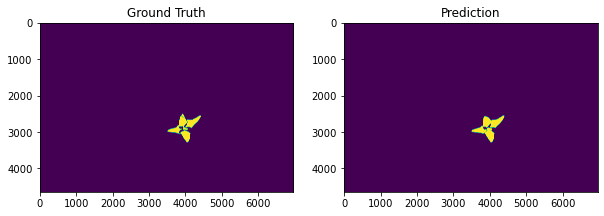

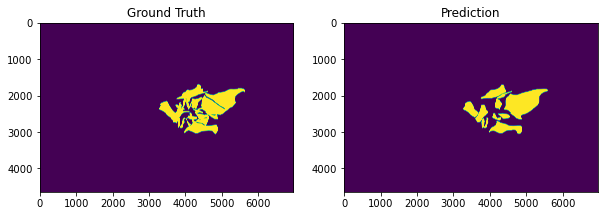

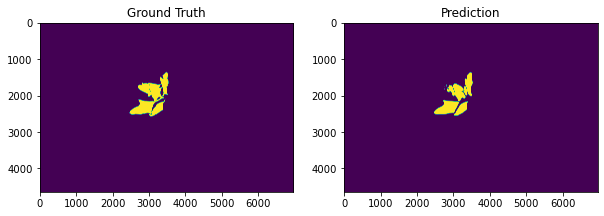

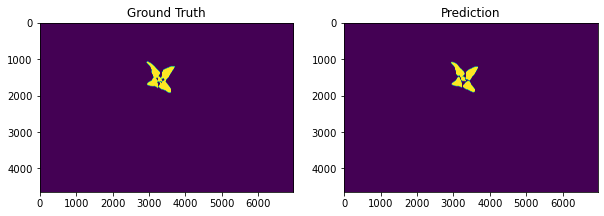

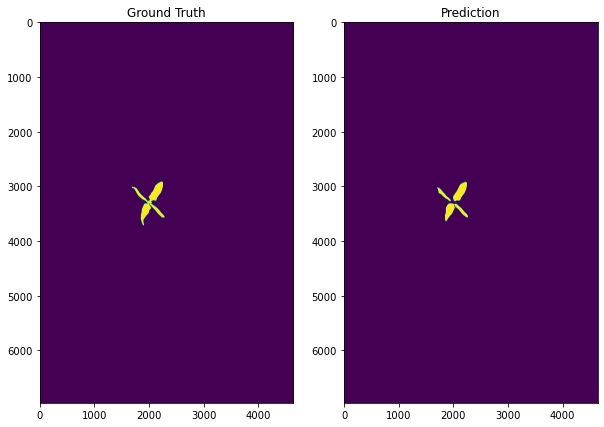

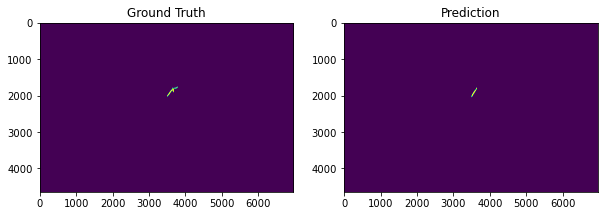

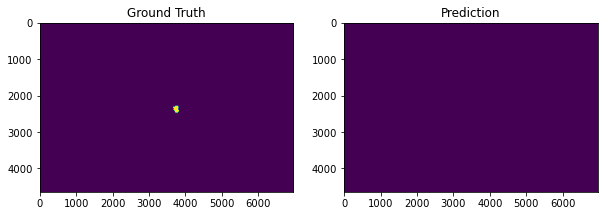

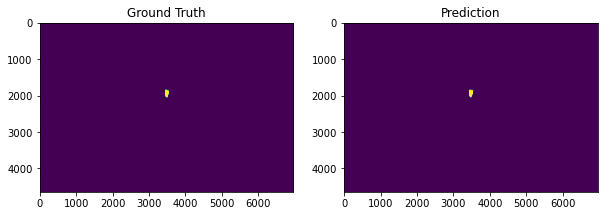

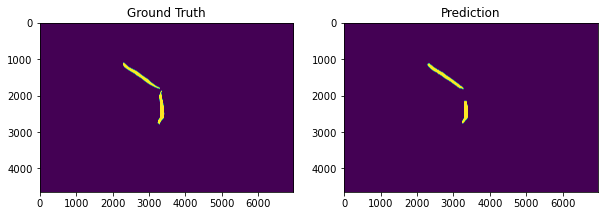

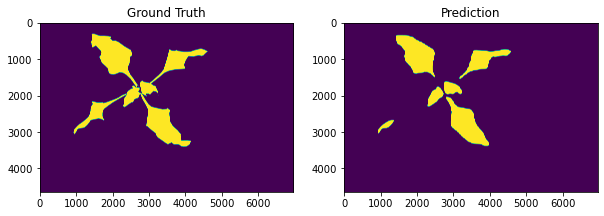

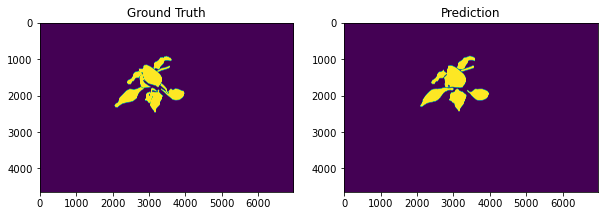

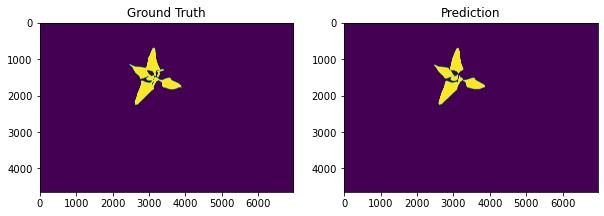

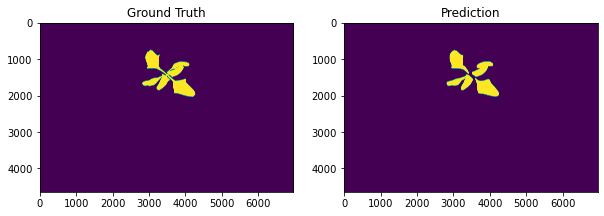

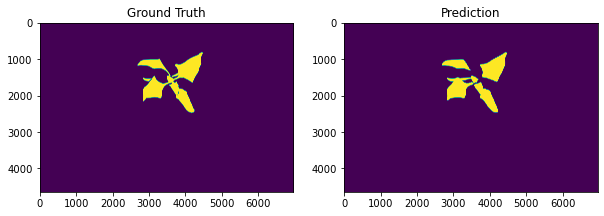

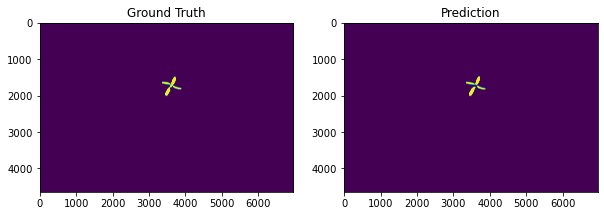

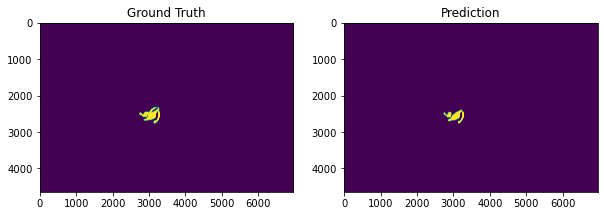

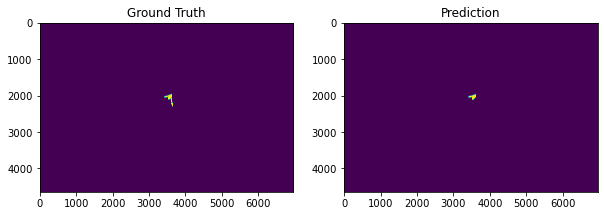

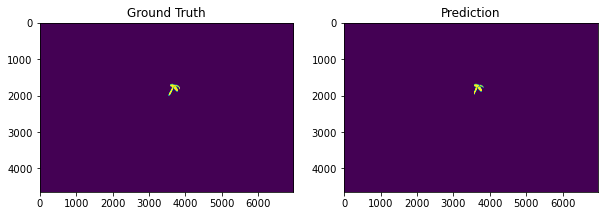

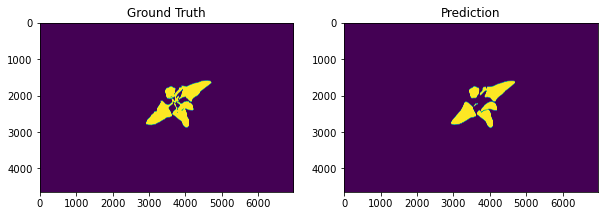

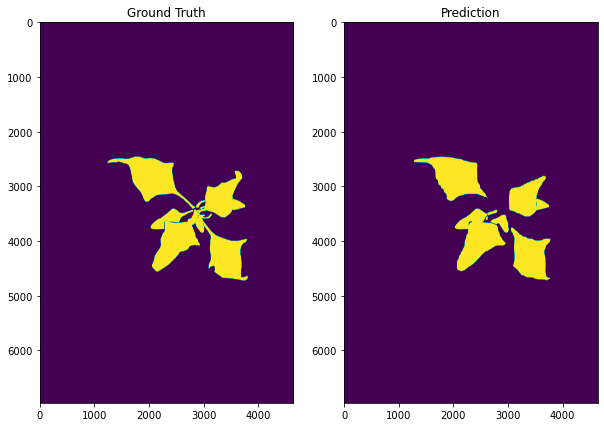

In [11]:
sample_ious = []
sample_dice = []

# sample = dataset.last()
for sample in dataset:
    
    print('\n --------------------------------------------------------------')
    print('\nSample: ', sample.filepath)

    # ------- get bboxes & masks for GROUND TRUTH and PREDICTIONS ------ #

    ground_truth_detections = sample.ground_truth.detections
    prediction_detections = sample.predictions.detections

    height = sample.height
    width  = sample.width

    ground_truth_bboxes = []
    ground_truth_masks = []

    prediction_bboxes = []
    prediction_masks = []
    detectron2_bboxes = []


    # get bboxes and masks from ground truth
    for d in ground_truth_detections:
        if (d.label == 'leaf'):
            ground_truth_bboxes.append(d.bounding_box)
            ground_truth_masks.append(d.mask)

    # get bboxes and masks from predictions
    for d in prediction_detections:
        if (d.label == 'leaf'):
            prediction_bboxes.append(d.bounding_box)
            prediction_masks.append(d.mask)
            detectron2_bboxes.append(d.original_bbox)



    # ---------- assemble PREDICTION mask for entire photo ------------ #
    complete_prediction_mask = np.zeros((height, width))


    for index, bbox in enumerate(prediction_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)], prediction_masks[index])

    print('Prediction pixel count: ', np.count_nonzero(complete_prediction_mask))



    # --------- assemble GROUND TRUTH mask for entire photo ----------- #
    complete_ground_truth_mask = np.zeros((height, width))

    for index, bbox in enumerate(ground_truth_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)], ground_truth_masks[index])

    print('Ground truth pixel count: ', np.count_nonzero(complete_ground_truth_mask))
    
    
     # ------- calculate Intersection Over Union (Jaccard Index) ------- #

    intersect = np.logical_and(complete_ground_truth_mask, complete_prediction_mask)
    union = np.logical_or(complete_ground_truth_mask, complete_prediction_mask)

    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        iou = intersect_pixels / union_pixels

    print('IOU:', iou)
    sample_ious.append(iou)
    
    # ------------ calculate Dice Coefficient (F1 Score) -------------- #
    
    dice = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        dice = (2 * intersect_pixels) / (np.count_nonzero(complete_ground_truth_mask) + np.count_nonzero(complete_prediction_mask))

    print('Dice:', dice)
    sample_dice.append(dice)

    # --------- visualize GROUND TRUTH and PREDICTION masks ----------- #
    f, axarr = plt.subplots(1,2)
    plt.rcParams['figure.figsize'] = [10, 10]

    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')

    axarr[0].imshow(complete_ground_truth_mask)
    axarr[1].imshow(complete_prediction_mask)
    
    display(f)
 

In [19]:
print(sample_ious)

sample_ious = np.array(sample_ious, dtype=np.float)

print(sample_ious)

# sample_ious[sample_ious == None] = np.nan

print('Min IOU: ', np.nanmin(sample_ious))
print('Max IOU: ', np.nanmax(sample_ious))
print('Average IOU: ', np.nanmean(sample_ious))

print('\n')
# sample_dice[sample_dice == None] = np.nan

sample_dice = np.array(sample_dice, dtype=np.float)

print('Min Dice: ', np.nanmin(sample_dice))
print('Max Dice: ', np.nanmax(sample_dice))
print('Average Dice: ', np.nanmean(sample_dice))





[       nan 0.8448159  0.24783389 0.07526806 0.                nan
 0.89598769 0.         0.73647455 0.89104342 0.87324044 0.77570093
 0.92887825 0.82542813 0.87833355 0.84885003 0.82686548 0.856339
 0.80048806 0.86807999 0.78514628 0.7931046  0.86623913 0.85983569
 0.45341323 0.         0.89724638 0.76563776 0.81032014 0.84608319
 0.90459267 0.90861376 0.89972815 0.83488504 0.73490572 0.63638886
 0.81182032 0.85639044 0.91173529]
[       nan 0.8448159  0.24783389 0.07526806 0.                nan
 0.89598769 0.         0.73647455 0.89104342 0.87324044 0.77570093
 0.92887825 0.82542813 0.87833355 0.84885003 0.82686548 0.856339
 0.80048806 0.86807999 0.78514628 0.7931046  0.86623913 0.85983569
 0.45341323 0.         0.89724638 0.76563776 0.81032014 0.84608319
 0.90459267 0.90861376 0.89972815 0.83488504 0.73490572 0.63638886
 0.81182032 0.85639044 0.91173529]
Min IOU:  0.0
Max IOU:  0.9288782483542601
Average IOU:  0.7229652437217374


Min Dice:  0.0
Max Dice:  0.9631279207454272
Average

/tmp/ipykernel_1430513/2493802070.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_ious = np.array(sample_ious, dtype=np.float)
/tmp/ipykernel_1430513/2493802070.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_dice = np.array(sample_dice, dtype=np.float)
